 # Import library

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
%%capture
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [82]:
sns.set_theme(style="ticks", palette="pastel")

# Data set loading

In [83]:
df = pd.read_csv('C:/Users/HP_ELITE/Desktop/ProjetAI/Customertravel.csv', delimiter=',')

In [84]:
df.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [85]:
df = df.rename(columns={'Target': 'Churn'})

# Explanatory data analysis

### 1. Summarize dataset

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Churn                       954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


In [87]:
df.describe()

,Age,ServicesOpted,Churn
count,954.00,954.00,954.00
mean,32.11,2.44,0.23
std,3.34,1.61,0.42
min,27.00,1.00,0.00
25%,30.00,1.00,0.00
50%,31.00,2.00,0.00
75%,35.00,4.00,0.00
max,38.00,6.00,1.00


In [88]:
df.columns

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Churn'],
      dtype='object')

### 2. Visualization

##### 2.1. Visualize numeric variables

In [89]:
# Split the numeric and categorical features
num_features = ['Age']
ordinal_features = ['AnnualIncomeClass', 'ServicesOpted']
cat_features = ['FrequentFlyer', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Churn']

In [90]:
sns.displot(data=df, x='Age', hue='Churn', kde=True)

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1 = sns.violinplot(data=df, x='Churn', y='Age', ax=ax1)
ax2 = sns.boxplot(data=df, x='Churn', y='Age', ax=ax2)
plt.tight_layout();

##### 2.2 Visualize categorical variables

In [92]:
df['Churn'].value_counts()

0    730
1    224
Name: Churn, dtype: int64

In [93]:
sns.countplot(data=df, x='Churn')

<AxesSubplot:xlabel='Churn', ylabel='count'>

In [117]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    sns.countplot(x=feature,
                  hue='Churn',
                  data=df,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Churn',
                data=df,
                ax=ax2)
    ax2.set_ylabel('Churn rate')


    plt.tight_layout();

In [118]:
for feature in (ordinal_features + cat_features[:-1]):
    plot_categorical(feature)

# Data preprocessing

### 1. One-hot encoding of categorical variables

In [96]:
cat_data = pd.DataFrame()
for feature in cat_features[:-1]:
    temp = pd.get_dummies(df[feature], prefix=feature)
    cat_data = pd.concat([cat_data, temp], axis=1)

### 2. Ordinal-encoding of ordinal variables

In [97]:
df['AnnualIncomeClass'] = df['AnnualIncomeClass'].map({'Low Income':0,
                             'Middle Income':1,
                             'High Income':2})

### 3. Min-max scale for numerical variables

In [98]:

features_to_scale = ['Age']
df[features_to_scale] = MinMaxScaler().fit_transform(df[features_to_scale])

scaler =MinMaxScaler()

df[num_features] = scaler.fit_transform(df[num_features])

### 4. Train test split

In [99]:
# merging the data
X = pd.concat([cat_data, df[ordinal_features], df[num_features]], axis=1)

In [100]:
y = df['Churn']

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### 5. Modeling

##### 5.1 AutoML model (lazypredict)

In [103]:
%%capture
!pip install lazypredict

In [104]:
from lazypredict.Supervised import LazyClassifier

In [105]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=100)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:03<00:00,  8.80it/s]

[LightGBM] [Info] Number of positive: 178, number of negative: 585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 763, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233290 -> initscore=-1.189828
[LightGBM] [Info] Start training from score -1.189828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [106]:
models.sort_values('F1 Score', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.91,0.85,0.85,0.91,0.03
BaggingClassifier,0.91,0.84,0.84,0.90,0.09
XGBClassifier,0.90,0.83,0.83,0.89,0.19
RandomForestClassifier,0.90,0.83,0.83,0.89,0.54
LGBMClassifier,0.89,0.82,0.82,0.89,0.17
ExtraTreesClassifier,0.89,0.82,0.82,0.89,0.52
LabelSpreading,0.87,0.81,0.81,0.87,0.13
LabelPropagation,0.87,0.81,0.81,0.87,0.07
ExtraTreeClassifier,0.87,0.80,0.80,0.87,0.02


##### 5.2 sklearn models

In [107]:
models = []
models.append(('LR', LogisticRegression(random_state = 100)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state = 100)))
models.append(('RF', RandomForestClassifier(random_state = 100)))
models.append(('SVM', SVC(gamma='auto', random_state = 100)))
models.append(('XGB', GradientBoostingClassifier(random_state = 100)))
models.append(("LightGBM", LGBMClassifier(random_state = 100)))
models.append(("CatBoost", CatBoostClassifier(random_state = 100, verbose = False)))

# evaluate each model in turn
results = []
names = []

In [108]:
for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

LR: (0.790576)
KNN: (0.869110)
CART: (0.910995)
RF: (0.895288)
SVM: (0.806283)
XGB: (0.905759)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 178, number of negative: 585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 763, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233290 -> initscore=-1.189828
[LightGBM] [Info] Start training from score -1.189828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

# Model tuning (Random Forest)

In [109]:
model = RandomForestClassifier(random_state=100)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

In [110]:
from sklearn.model_selection import GridSearchCV
rf_clf = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      scoring='balanced_accuracy',
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)

In [111]:
best_rf_clf

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'], 'max_depth': [6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100]},
             scoring='balanced_accuracy', verbose=False)

# Results of the best model (RandomForestClassifier)

In [112]:
y_pred = best_rf_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8691099476439791


In [113]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_clf.classes_)
disp.plot()

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       145
           1       0.86      0.54      0.67        46

    accuracy                           0.87       191
   macro avg       0.87      0.76      0.79       191
weighted avg       0.87      0.87      0.86       191



# Feature analysis

In [115]:
models2 = []
models2.append(('DecisionTree', DecisionTreeClassifier(random_state = 42)))
models2.append(('RF', RandomForestClassifier( random_state = 42)))
models2.append(('XGB', GradientBoostingClassifier( random_state = 42)))
models2.append(("LightGBM", LGBMClassifier( random_state = 42)))
models2.append(("CatBoost", CatBoostClassifier(random_state = 42, verbose = False)))

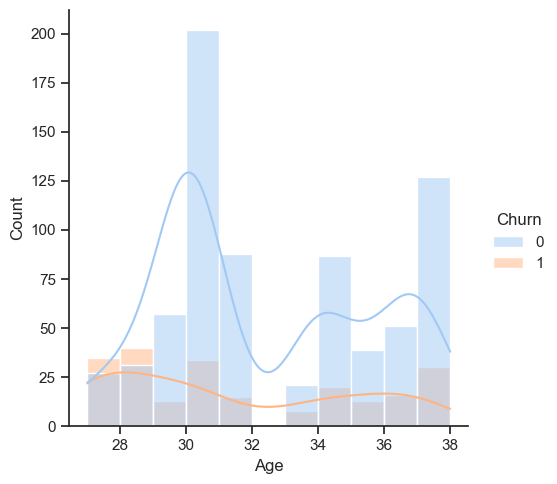

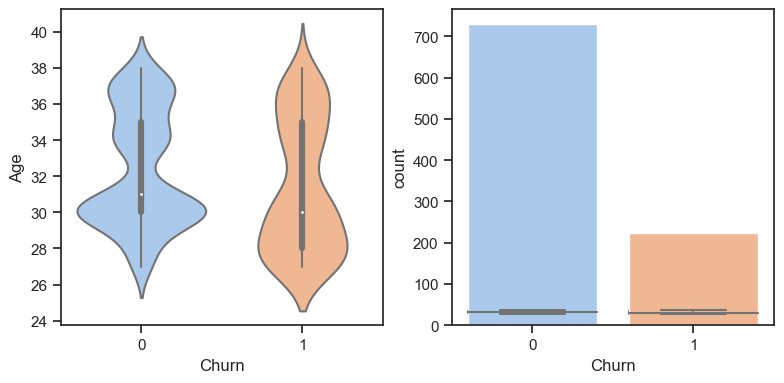

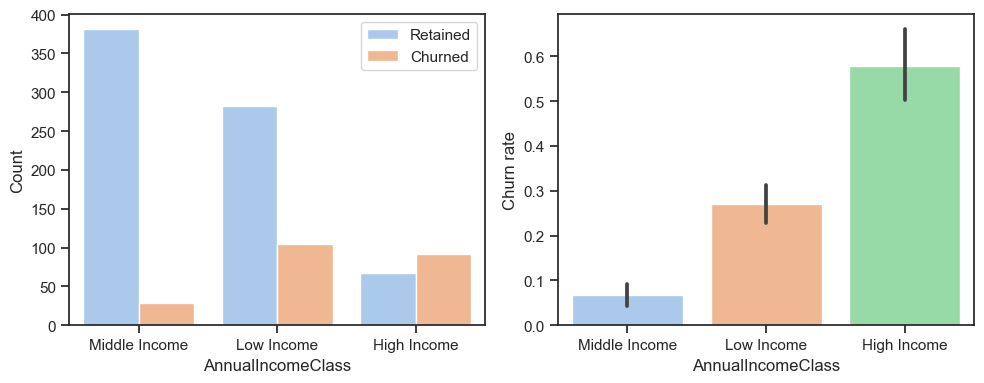

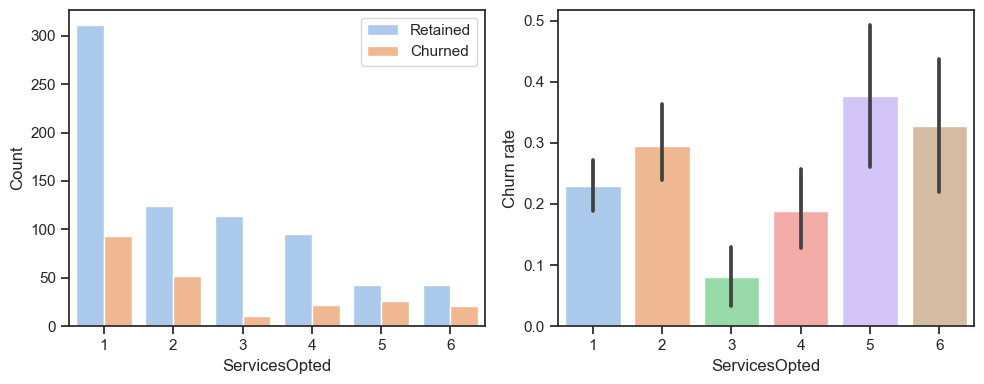

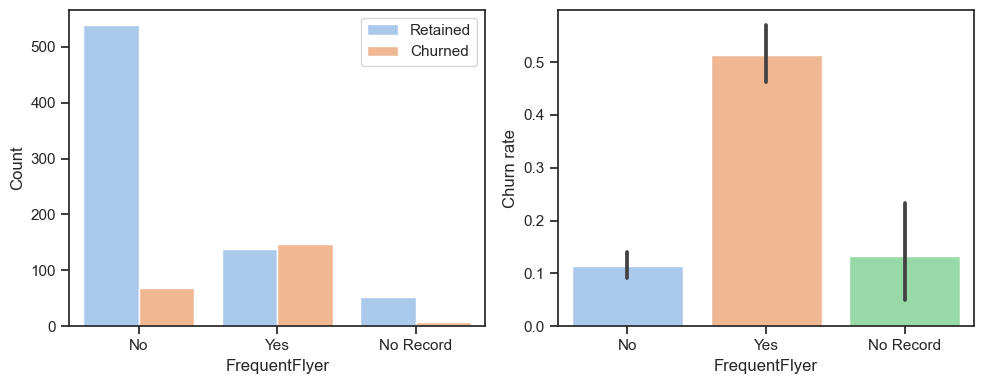

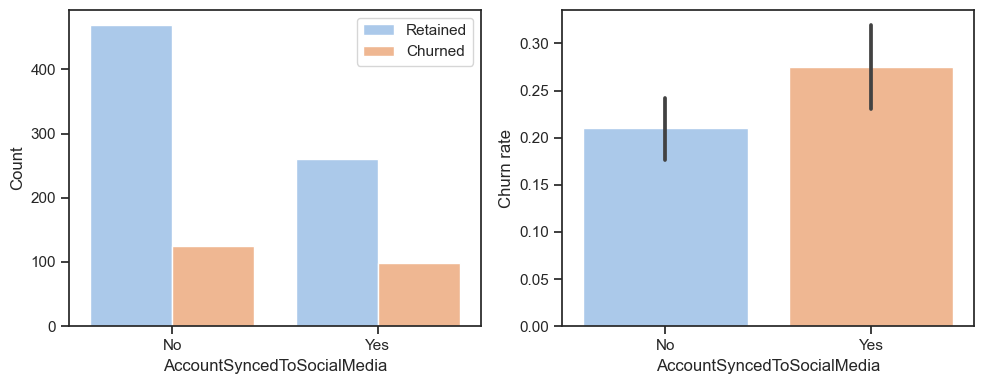

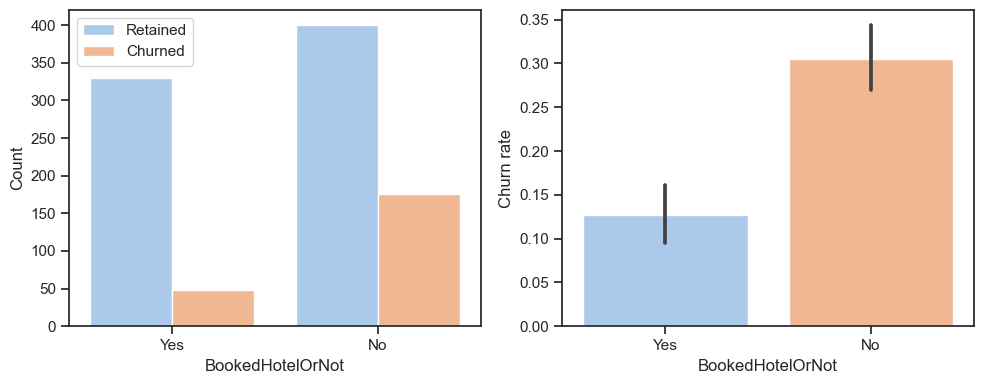

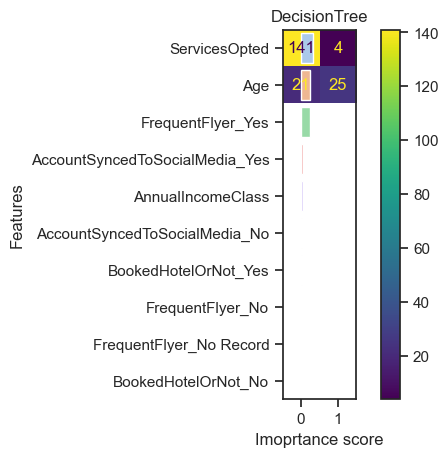

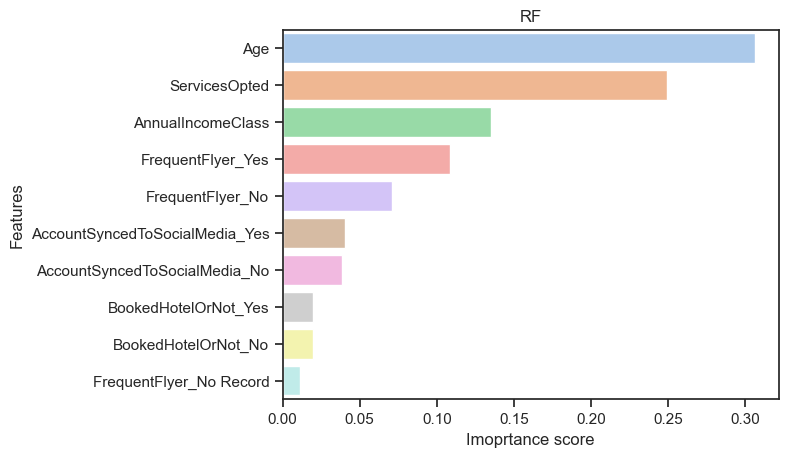

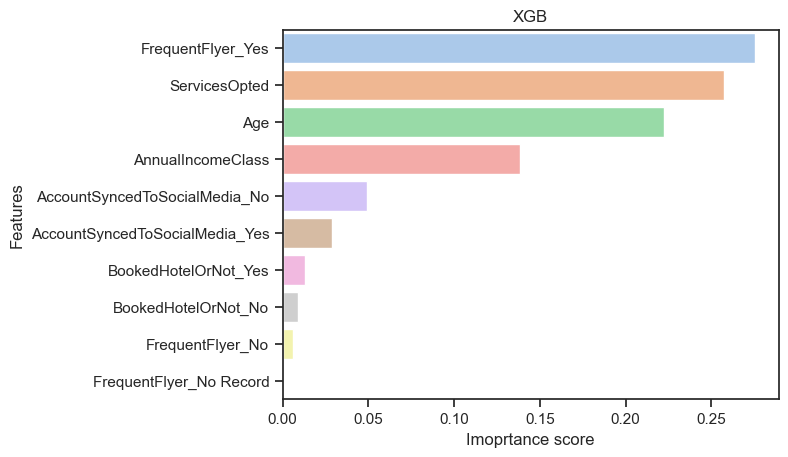

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 178, number of negative: 585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 763, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233290 -> initscore=-1.189828
[LightGBM] [Info] Start training from score -1.189828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

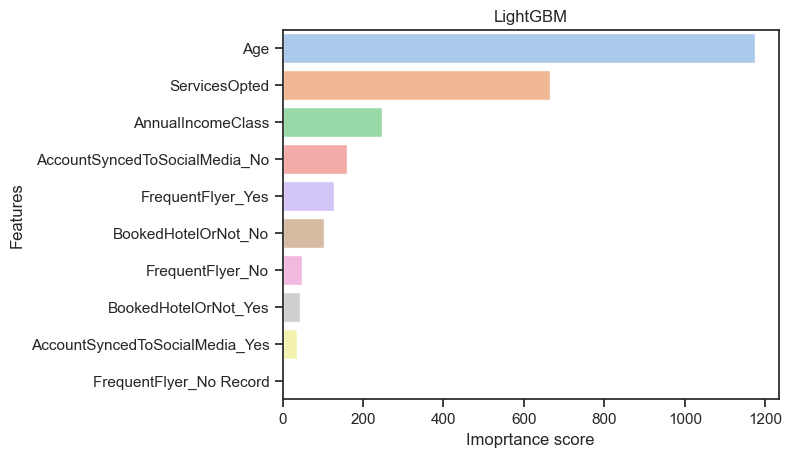

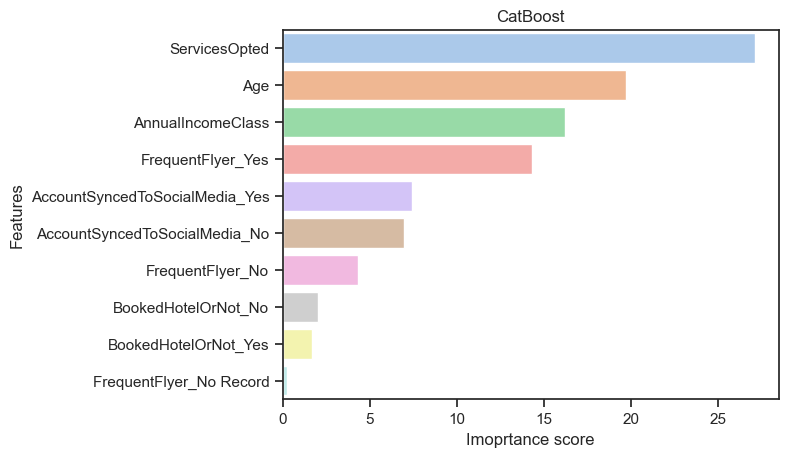

In [116]:
for name, model in models2:
        base = model.fit(X_train,y_train)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(base.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Imoprtance score')
        plt.ylabel('Features')
        plt.title(name)
        plt.show()